# Tutorial 08 - Processing seismic data II

## f-k Filtering

Frequency-wavenumber domain filtering is a common technique used for removing the ground roll (signal introduced by surface waves) within seismic reflection data.  This process involves a few different steps:

1. Transform seismic traces from time-space domain to frequency-wavenumber domain.
2. Mask out portion of the frequency-wavenumber spectrum which contains the ground roll.
3. Transform the seismic traces back from the frequency-wavenumber domain to the time-space domain.

A question you may be asking for step 2 is what portion of the spectrum we want to mask out.  It's first important to understand which parts of the shotgather correspond to specific parts of the frequency-wavenumber spectrum.  Consider the following shotgather:

<img src="shotgather_annotated.png" alt="Annotated shotgather." style="max-width: 75%; height: auto; "/>

When transformed to the frequency-wavenumber domain, the resulting spectrum would look something like the following:

<img src="fk_spectrum_annotated.png" alt="Annotated f-k spectrum." style="max-width: 75%; height: auto; "/>

Thus, we want to create a mask that will allow us to remove the "Ground Roll" portion of the frequency-wavenumber spectrum.

## Preamble

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pestoseis

## Import Data

First, let's start off by importing a simple dataset containing a shotgather for a homogeneous elastic medium.

<IPython.core.display.Javascript object>


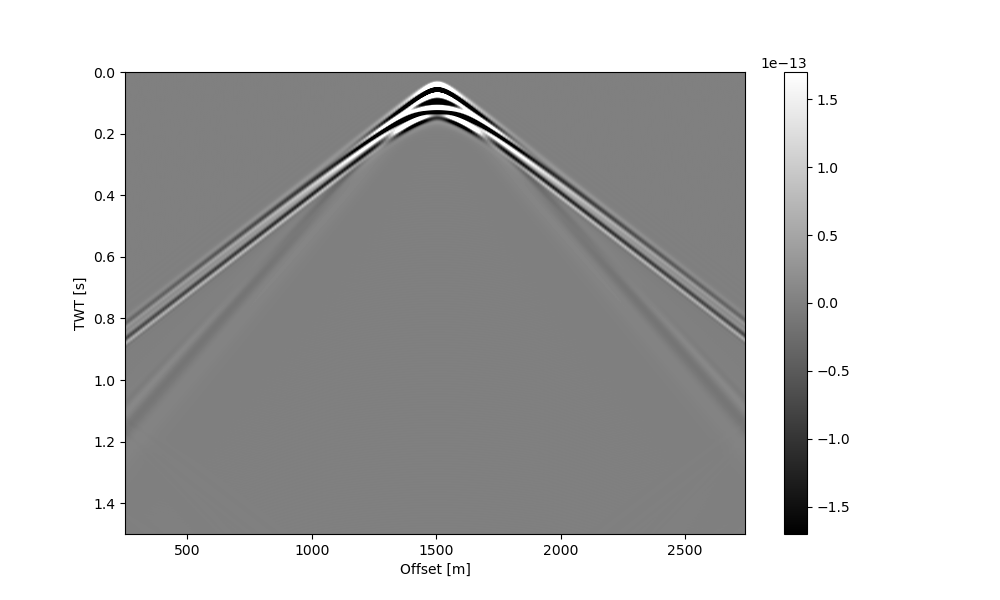

In [3]:
# Import either "traces_homogeneous.npy" or "traces_layered.npy"
seismograms = np.load("traces_homogeneous.npy")[:, :, 1]

# Characteristics of the receivers assigned when generating the forward data
dt = 0.0005
dx = 1.0
offset = np.array([250, 2740])

plt.figure(figsize=[10, 6])
pestoseis.reflectionseismo.reflseismo.imgshotgath(
    seismograms, 
    dt=dt, 
    offset=offset,
    amplitudeclip=0.1
)

There are two clear features present within this shotgather:
1. Direct arrival (earlier arrival)
2. Ground roll (later arrival)

Our objective is to remove the ground roll from this shotgather so that it appears as though only the direct arrival would be present.

## Transform to Frequency-Wavenumber Domain

Before we can start filtering anything, we need to transform the data to the frequency-wavenumber domain.  We can accomplish this using `transform_tx_to_fk()`.

In [4]:
fk_seis = pestoseis.reflectionseismo.reflseismo.transform_tx_to_fk(seismograms)

We can then plot the frequency-wavenumber spectrum for this dataset.

<IPython.core.display.Javascript object>


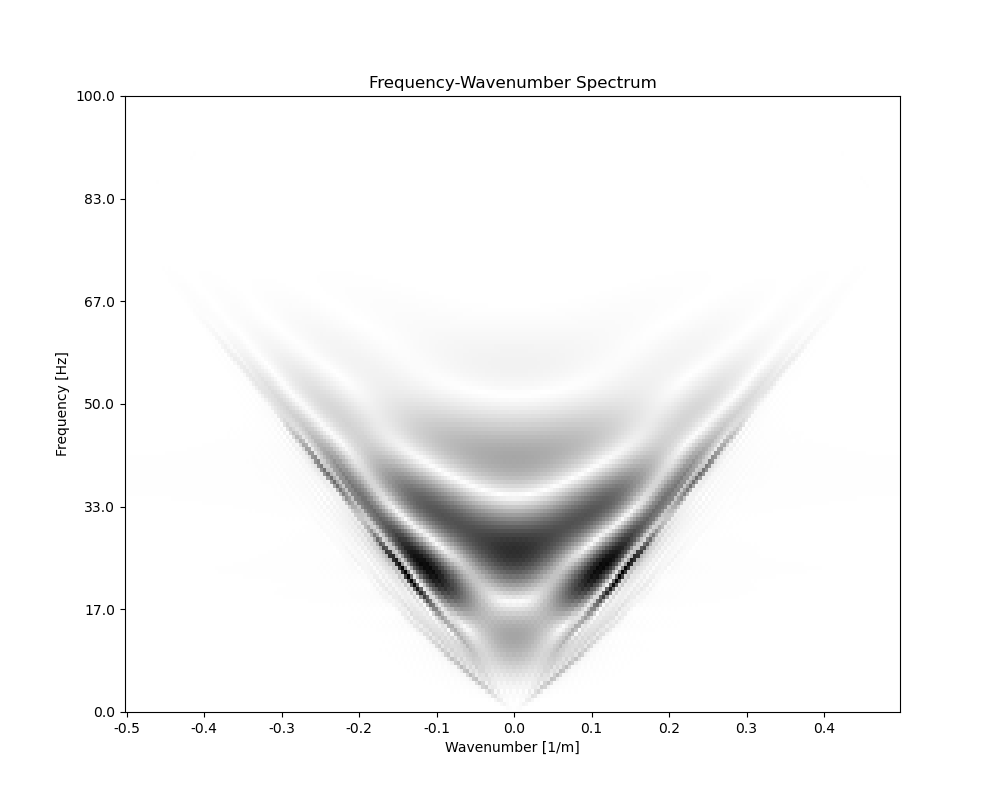

In [5]:
pestoseis.reflectionseismo.reflseismo.plot_fk_spectrum(fk_seis, dt, dx, interactive=False, ylim=150)

## Remove the Ground Roll

Now that we have the data in the frequency-wavenumber domain, we can go about removing the effects of the ground roll.  We can construct a mask for the portion of the spectrum we want to remove by setting `interactive=True` when plotting the f-k spectrum.  Simply click on the resulting plot to draw in a polygon that traces the region shown in the figure at the start of the notebook (red region indicated by "Ground Roll").

<IPython.core.display.Javascript object>


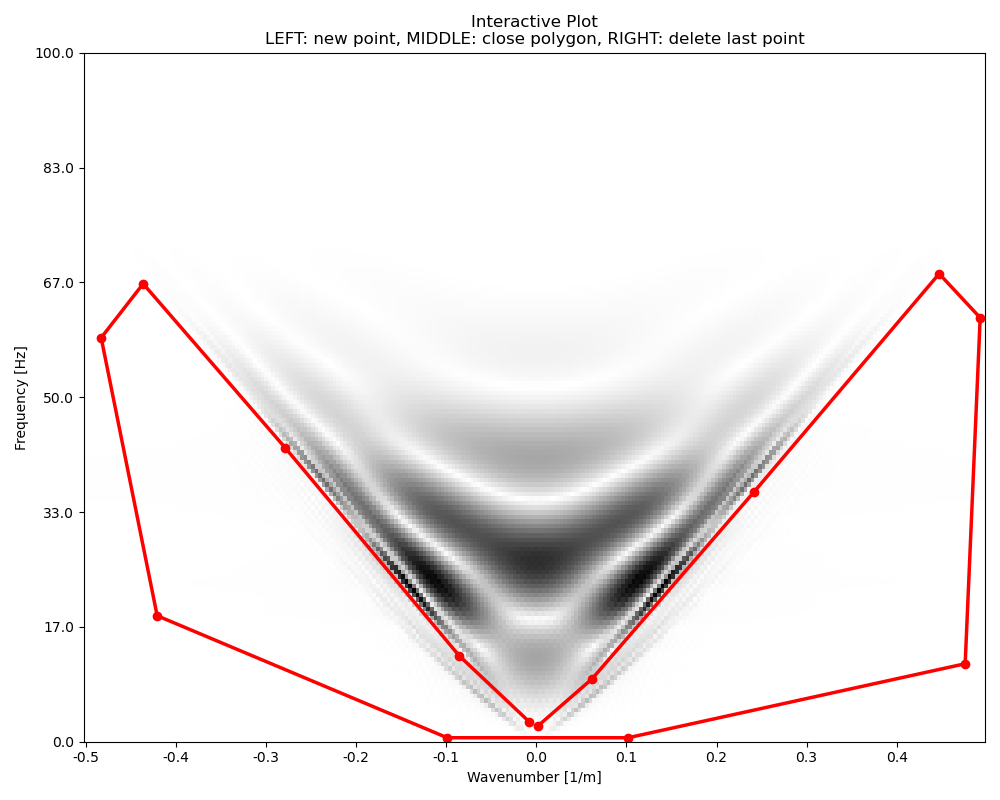

In [6]:
poly = pestoseis.reflectionseismo.reflseismo.plot_fk_spectrum(fk_seis, dt, dx, interactive=True, ylim=150)

We now convert this to a mask and apply it to the frequency-wavenumber spectrum.

In [7]:
mask = pestoseis.reflectionseismo.reflseismo.mask_from_polygon(fk_seis, poly)
fk_seis *= mask

Let's take a look at the filtered data in the f-k domain.

<IPython.core.display.Javascript object>


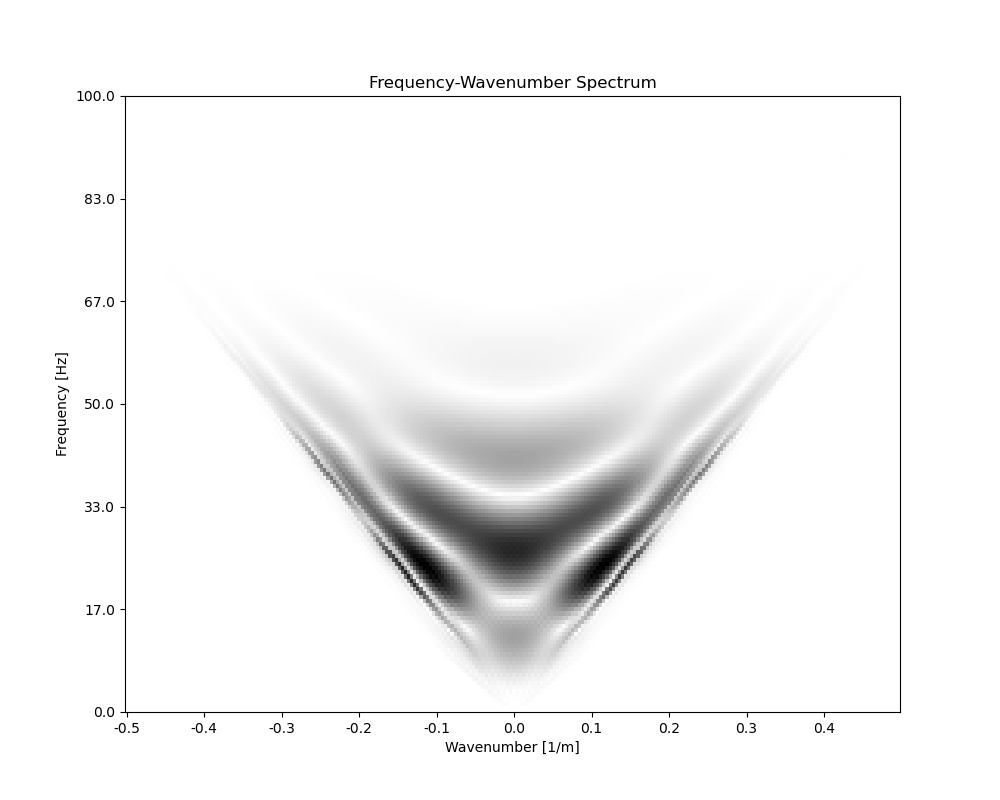

In [8]:
pestoseis.reflectionseismo.reflseismo.plot_fk_spectrum(fk_seis, dt, dx, interactive=False, ylim=150)

## Convert back to Time-Space Domain

The final step is now to transform back to the time-space domain so that we can visualize our filtered shotgather.

<IPython.core.display.Javascript object>


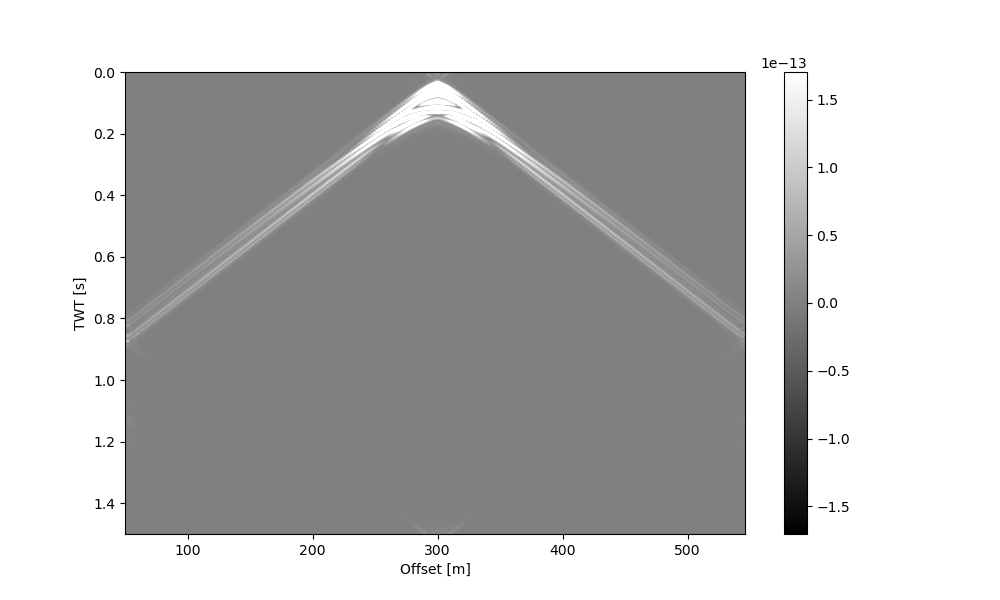

In [9]:
seismograms_filtered = pestoseis.reflectionseismo.reflseismo.transform_fk_to_tx(fk_seis)

plt.figure(figsize=[10, 6])
pestoseis.reflectionseismo.reflseismo.imgshotgath(
    seismograms_filtered, 
    dt=0.0005, 
    offset=np.array([50, 546]),
    amplitudeclip=0.1
)

Since we've had to get the magnitude of the resulting FFT output, we've lost the information on which parts of the shotgather are positive and negative.  Luckily, we can recover this quite easily using the `get_pm_mask()` function.

In [10]:
seismograms_filtered *= pestoseis.reflectionseismo.reflseismo.get_pm_mask(seismograms)

Finally, let's compare the original shotgather with the filtered one.

<IPython.core.display.Javascript object>


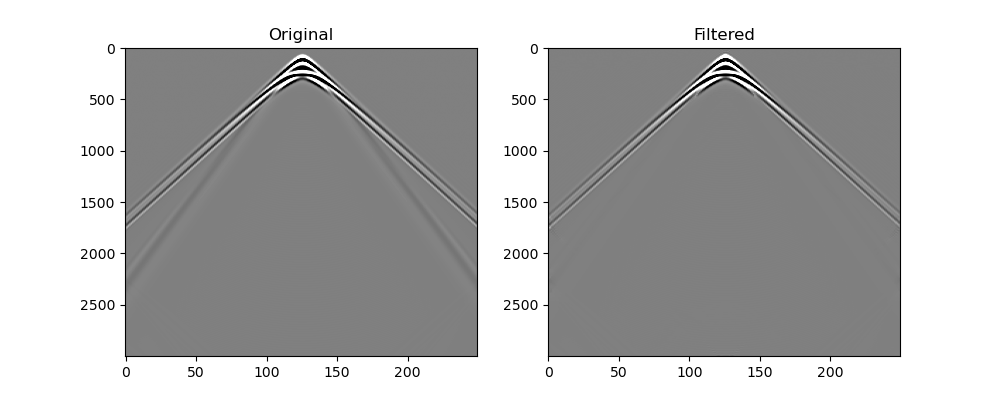

In [11]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cbar_range = np.max([np.abs(np.min(seismograms)), np.abs(np.max(seismograms))])
cbar_range = np.array([-cbar_range, cbar_range]) * 0.1

ax1.imshow(seismograms.T, aspect="auto", cmap="gray", vmin=cbar_range[0], vmax=cbar_range[1])
ax1.set_title("Original")

ax2.imshow(seismograms_filtered.T, aspect="auto", cmap="gray", vmin=cbar_range[0], vmax=cbar_range[1])
ax2.set_title("Filtered")
plt.show()

Not bad, we've removed most of the effects of the ground roll!

If you want to try out a set of seismograms with additional reflections present, try out the dataset `traces_layered.npy` for a set of measurements taken in a layered model.